/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Usando dispositivo: cuda
<PIL.PngImagePlugin.PngImageFile image mode=L size=3840x2160 at 0x79BE8C2F48E0>
Número de imagens carregadas: 500
Número de máscaras carregadas: 500
(3840, 2160)
(3840, 2160)
0 255 113.82261063689558
0 1 0.004637225115740741


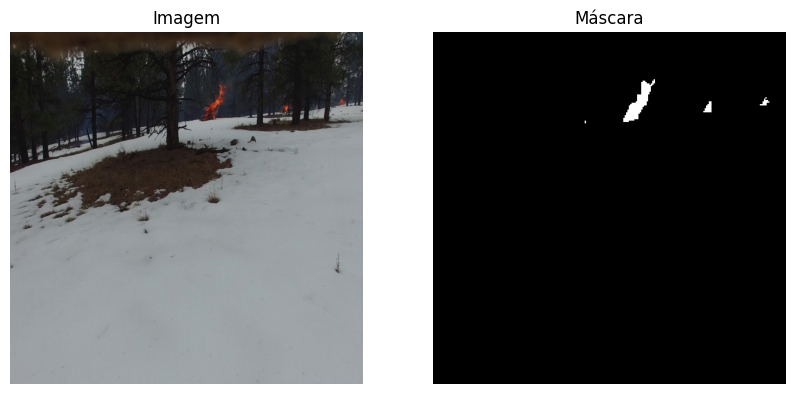

Preparação concluída!


In [1]:
# O dataset usado foi o FLAME, que pode ser encontrado em 
# 'https://github.com/AlirezaShamsoshoara/Fire-Detection-UAV-Aerial-Image-Classification-Segmentation-UnmannedAerialVehicle'

import os
from PIL import Image
import numpy as np
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split
import matplotlib.pyplot as plt
from albumentations import (
    HorizontalFlip, RandomCrop, ColorJitter, Normalize, Compose
)

# Verifica se a GPU está disponível
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Função para carregar imagens e máscaras
def load_images_from_folder(folder):
    images = []
    for filename in sorted(os.listdir(folder)):  # Ordena para manter correspondência
        if int(filename[6:-4]) < 500:
            img = Image.open(os.path.join(folder, filename))
            if img is not None:
                images.append(img)
    return images

# Pastas de imagens e máscaras
images_folder = '/kaggle/input/fire-signs-2/Images/Images'
masks_folder = '/kaggle/input/fire-signs-2/Masks/Masks'

# Carrega as imagens e máscaras
images = load_images_from_folder(images_folder)
masks = load_images_from_folder(masks_folder)
print(masks[0])

print(f"Número de imagens carregadas: {len(images)}")
print(f"Número de máscaras carregadas: {len(masks)}")



# Dataset customizado para carregar imagens e máscaras
class ImageMaskDataset(Dataset):
    def __init__(self, images, masks, target_size, target_size_mask):
        self.images = images
        self.masks = masks
        self.strong_transform = Compose([
            HorizontalFlip(p=0.5),
            ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1, p=0.8)
        ])
        self.transform_image = transforms.Compose([
            transforms.Resize(target_size),
            transforms.ToTensor(),  # Converte para [C, H, W] com valores em [0, 1]
        ])
        self.transform_mask = transforms.Compose([
            transforms.Resize(target_size_mask, interpolation=transforms.InterpolationMode.NEAREST),
            transforms.ToTensor(),  # Máscaras podem ser binárias
        ])
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        #items = self.strong_transform(image=np.array(self.images[idx]), mask=np.array(self.masks[idx]))
        #image = Image.fromarray(items["image"].astype(np.uint8))
        #mask = Image.fromarray(items["mask"].astype(np.uint8))
        image = self.transform_image(self.images[idx])
        mask = self.transform_mask(self.masks[idx])*255
        return image, mask

# Hiper-parâmetros
target_size = (1024, 1024)
target_size_mask = (256, 256)
thold = [0.5, 0.75]
lr = 1e-5
num_epochs = 5
batch_size = 5



print(images[0].size)
print(masks[0].size)
print(np.min(images[0]), np.max(images[0]), np.mean(images[0]))
print(np.min(masks[0]), np.max(masks[0]), np.mean(masks[0]))

# Cria o dataset
dataset = ImageMaskDataset(images, masks, target_size, target_size_mask)

image, mask = dataset[0]
image = image.permute(1, 2, 0).numpy()  # Converte para [H, W, C] para visualização
mask = mask.squeeze().numpy()  # Remove o canal extra da máscara

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Imagem")
plt.imshow(image)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Máscara")
plt.imshow(mask, cmap="gray")
plt.axis("off")
plt.show()

# Divide o dataset em treino, validação e teste
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])
"""
# Cria os DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Verifica um lote de exemplo
for images_batch, masks_batch in train_loader:
    images_batch = images_batch.to(device)
    masks_batch = masks_batch.to(device)
    print(f"Lote de imagens: {images_batch.shape}, no dispositivo: {images_batch.device}")
    print(f"Lote de máscaras: {masks_batch.shape}, no dispositivo: {masks_batch.device}")
    break  # Apenas para testar o primeiro lote
"""
print("Preparação concluída!")

In [2]:
#Get bounding boxes from mask.
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [3]:
from albumentations import (
    HorizontalFlip, RandomCrop, ColorJitter, Normalize, Compose
)
from albumentations.pytorch import ToTensorV2


weak_transform = Compose([
    HorizontalFlip(p=0.5),
    Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))
])

strong_transform = Compose([
    HorizontalFlip(p=0.5),
    RandomCrop(height=32, width=32, p=1.0),
    ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1, p=0.8),
    Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))
])



In [4]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    
    # Se item for uma tupla, descompacte
    image, label = item
    ground_truth_mask = np.array(label)[0]

    # Inspecione a imagem original e a máscara
    #print(f"Imagem original: {image}")
    #print(f"Máscara ground truth: {ground_truth_mask.shape}")

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)
    #print(f"Bounding box prompt: {prompt}")

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")
    inputs["pixel_values"] = image
    #print(f"Inputs após processador: {inputs}")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs


In [5]:
# Initialize the processor
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

In [6]:
# Create an instance of the SAMDataset
train_dataset = SAMDataset(dataset=train_dataset, processor=processor)
val_dataset = SAMDataset(dataset=val_dataset, processor=processor)
test_dataset = SAMDataset(dataset=test_dataset, processor=processor)

In [7]:
# Create a DataLoader instance for the training dataset
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=False)

In [8]:
# Load the model
from transformers import SamModel
model = SamModel.from_pretrained("facebook/sam-vit-base")
# Congelar todos os parâmetros do modelo
for name, module in model.named_children():
    print(name)
# Congelar todos os parâmetros do modelo
for param in model.parameters():
    param.requires_grad = False

# Tornar apenas o mask_decoder treinável
for param in model.mask_decoder.parameters():
    param.requires_grad = True


# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

shared_image_embedding
vision_encoder
prompt_encoder
mask_decoder


In [9]:
from torch.optim import Adam
# Initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=lr, weight_decay=0)
#Try DiceFocalLoss, FocalLoss, DiceCELoss
class DiceLoss(torch.nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = torch.sigmoid(inputs)  # Aplica a função sigmoide
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()
        dice = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)
        return 1 - dice

seg_loss = DiceLoss()

  0%|          | 0/70 [00:00<?, ?it/s]It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


F1-score para thresholder  0.5
Batch 0: GT sum: 1077.0, Pred sum: 1064.0
F1-score para thresholder  0.75
Batch 0: GT sum: 1077.0, Pred sum: 1021.0


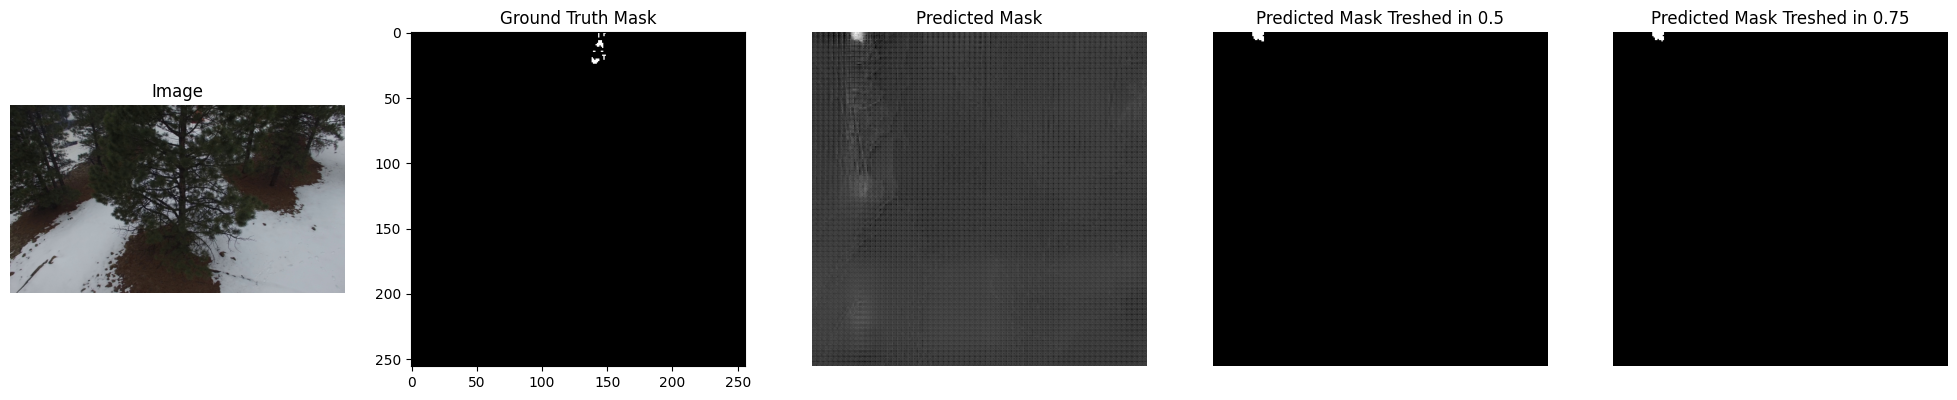

 14%|█▍        | 10/70 [00:39<03:42,  3.70s/it]

F1-score para thresholder  0.5
Batch 10: GT sum: 909.0, Pred sum: 427.0
F1-score para thresholder  0.75
Batch 10: GT sum: 909.0, Pred sum: 351.0


 29%|██▊       | 20/70 [01:15<03:02,  3.66s/it]

F1-score para thresholder  0.5
Batch 20: GT sum: 1974.0, Pred sum: 116.0
F1-score para thresholder  0.75
Batch 20: GT sum: 1974.0, Pred sum: 63.0


 36%|███▌      | 25/70 [01:34<02:46,  3.69s/it]

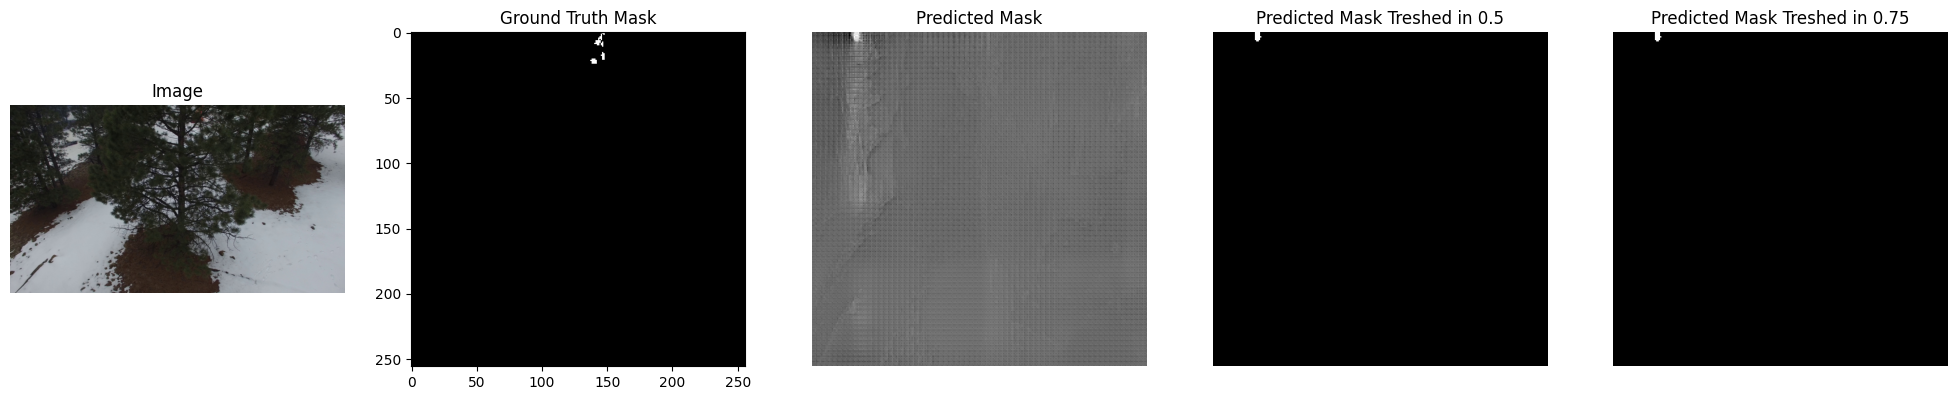

 43%|████▎     | 30/70 [01:54<02:33,  3.85s/it]

F1-score para thresholder  0.5
Batch 30: GT sum: 1253.0, Pred sum: 199.0
F1-score para thresholder  0.75
Batch 30: GT sum: 1253.0, Pred sum: 165.0


 57%|█████▋    | 40/70 [02:33<01:55,  3.86s/it]

F1-score para thresholder  0.5
Batch 40: GT sum: 666.0, Pred sum: 221.0
F1-score para thresholder  0.75
Batch 40: GT sum: 666.0, Pred sum: 126.0


 71%|███████▏  | 50/70 [03:13<01:21,  4.07s/it]

F1-score para thresholder  0.5
Batch 50: GT sum: 1204.0, Pred sum: 711.0
F1-score para thresholder  0.75
Batch 50: GT sum: 1204.0, Pred sum: 417.0


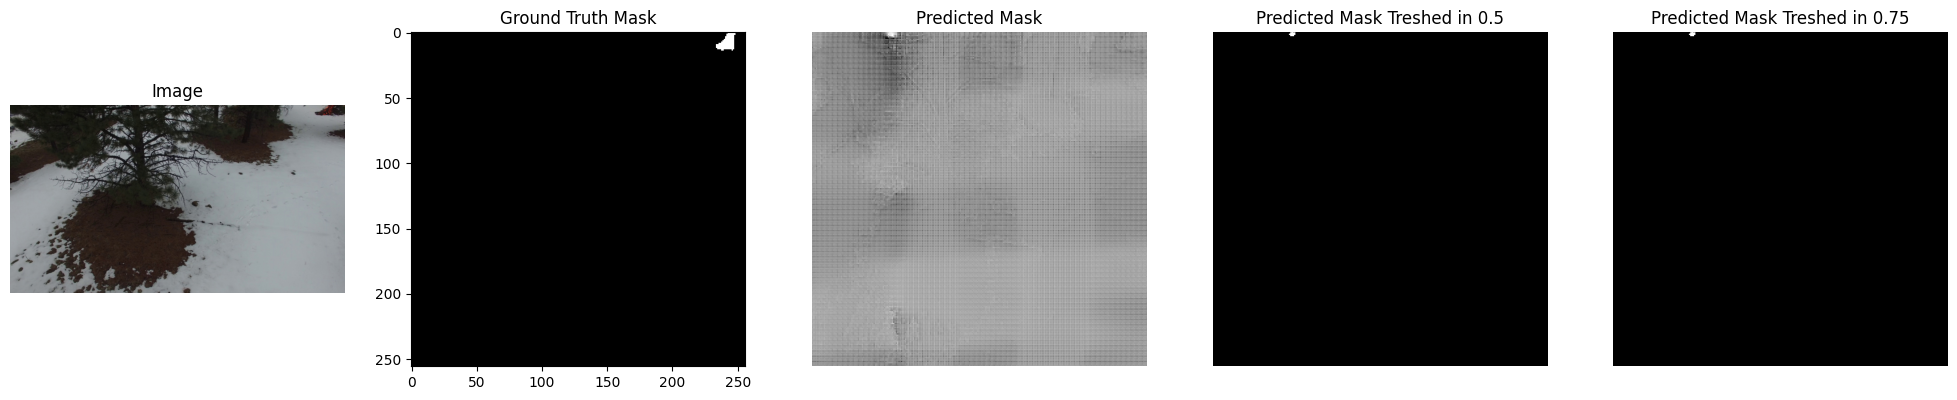

 86%|████████▌ | 60/70 [03:55<00:40,  4.07s/it]

F1-score para thresholder  0.5
Batch 60: GT sum: 704.0, Pred sum: 160.0
F1-score para thresholder  0.75
Batch 60: GT sum: 704.0, Pred sum: 122.0


100%|██████████| 70/70 [04:35<00:00,  3.94s/it]


EPOCH: 0
Mean loss: 0.9387823522090912
Mean F1-Score: 0.0556509875131309


  0%|          | 0/70 [00:00<?, ?it/s]

F1-score para thresholder  0.5
Batch 0: GT sum: 687.0, Pred sum: 655.0
F1-score para thresholder  0.75
Batch 0: GT sum: 687.0, Pred sum: 629.0


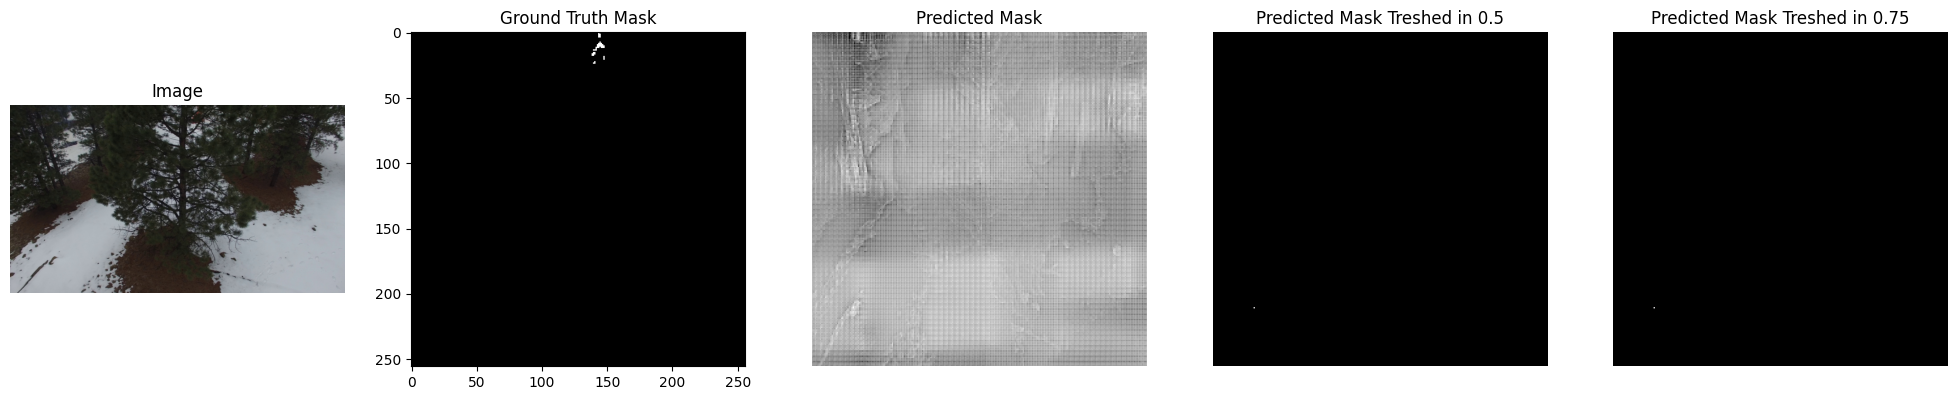

 14%|█▍        | 10/70 [00:37<03:37,  3.62s/it]

F1-score para thresholder  0.5
Batch 10: GT sum: 1590.0, Pred sum: 1058.0
F1-score para thresholder  0.75
Batch 10: GT sum: 1590.0, Pred sum: 1009.0


 29%|██▊       | 20/70 [01:13<02:58,  3.57s/it]

F1-score para thresholder  0.5
Batch 20: GT sum: 1170.0, Pred sum: 1705.0
F1-score para thresholder  0.75
Batch 20: GT sum: 1170.0, Pred sum: 1644.0


 36%|███▌      | 25/70 [01:31<02:41,  3.58s/it]

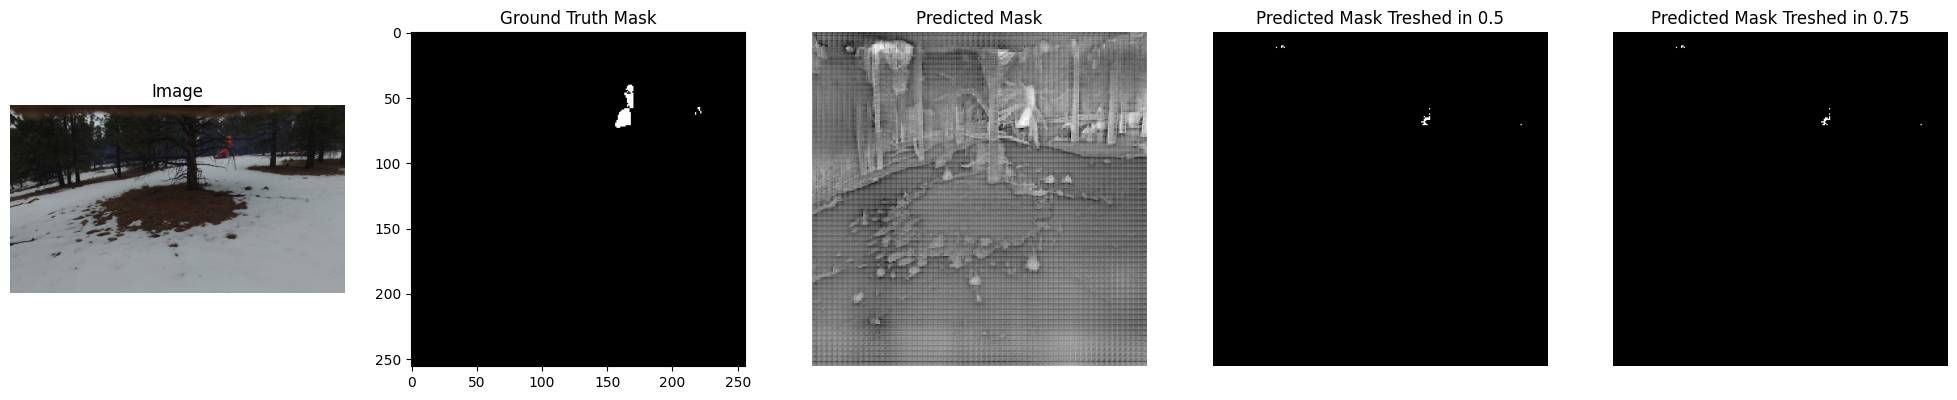

 43%|████▎     | 30/70 [01:50<02:28,  3.72s/it]

F1-score para thresholder  0.5
Batch 30: GT sum: 866.0, Pred sum: 403.0
F1-score para thresholder  0.75
Batch 30: GT sum: 866.0, Pred sum: 395.0


 57%|█████▋    | 40/70 [02:26<01:48,  3.62s/it]

F1-score para thresholder  0.5
Batch 40: GT sum: 1096.0, Pred sum: 702.0
F1-score para thresholder  0.75
Batch 40: GT sum: 1096.0, Pred sum: 681.0


 71%|███████▏  | 50/70 [03:02<01:11,  3.59s/it]

F1-score para thresholder  0.5
Batch 50: GT sum: 1105.0, Pred sum: 822.0
F1-score para thresholder  0.75
Batch 50: GT sum: 1105.0, Pred sum: 811.0


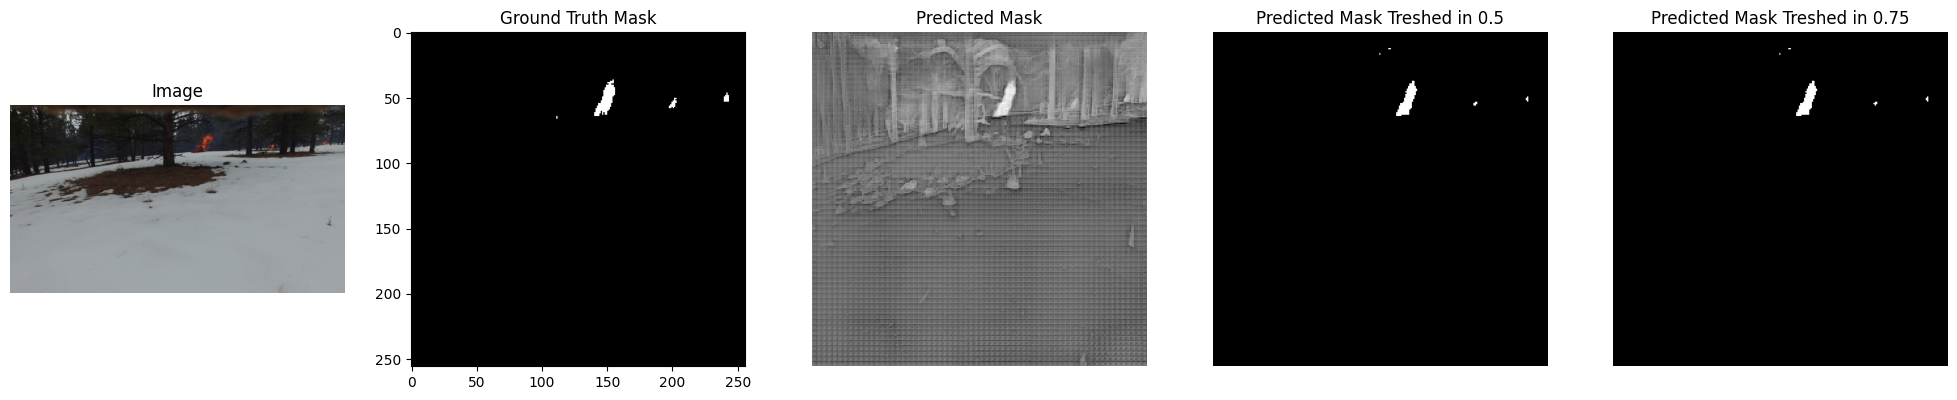

 86%|████████▌ | 60/70 [03:40<00:36,  3.60s/it]

F1-score para thresholder  0.5
Batch 60: GT sum: 1212.0, Pred sum: 1089.0
F1-score para thresholder  0.75
Batch 60: GT sum: 1212.0, Pred sum: 1076.0


100%|██████████| 70/70 [04:16<00:00,  3.66s/it]


EPOCH: 1
Mean loss: 0.42268866556031365
Mean F1-Score: 0.5824474980901615


  0%|          | 0/70 [00:00<?, ?it/s]

F1-score para thresholder  0.5
Batch 0: GT sum: 1075.0, Pred sum: 838.0
F1-score para thresholder  0.75
Batch 0: GT sum: 1075.0, Pred sum: 812.0


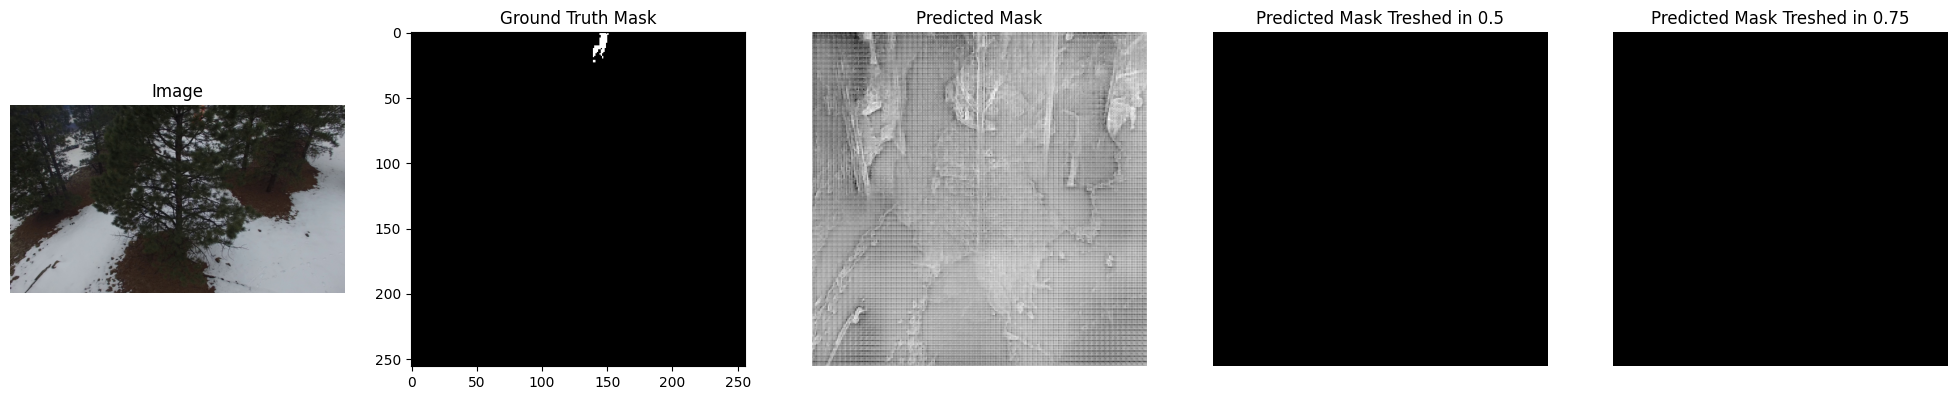

 14%|█▍        | 10/70 [00:37<03:36,  3.61s/it]

F1-score para thresholder  0.5
Batch 10: GT sum: 1796.0, Pred sum: 1610.0
F1-score para thresholder  0.75
Batch 10: GT sum: 1796.0, Pred sum: 1600.0


 29%|██▊       | 20/70 [01:13<03:01,  3.63s/it]

F1-score para thresholder  0.5
Batch 20: GT sum: 1168.0, Pred sum: 864.0
F1-score para thresholder  0.75
Batch 20: GT sum: 1168.0, Pred sum: 853.0


 36%|███▌      | 25/70 [01:31<02:41,  3.59s/it]

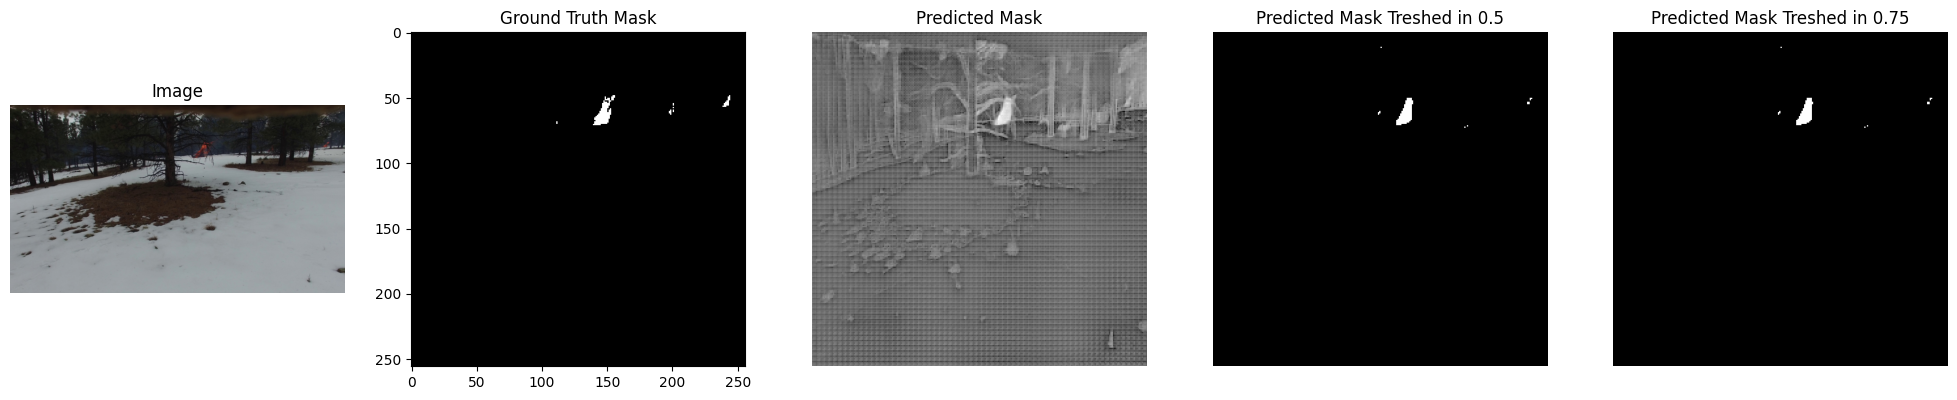

 43%|████▎     | 30/70 [01:50<02:27,  3.68s/it]

F1-score para thresholder  0.5
Batch 30: GT sum: 745.0, Pred sum: 600.0
F1-score para thresholder  0.75
Batch 30: GT sum: 745.0, Pred sum: 585.0


 57%|█████▋    | 40/70 [02:26<01:47,  3.58s/it]

F1-score para thresholder  0.5
Batch 40: GT sum: 951.0, Pred sum: 817.0
F1-score para thresholder  0.75
Batch 40: GT sum: 951.0, Pred sum: 810.0


 71%|███████▏  | 50/70 [03:02<01:11,  3.58s/it]

F1-score para thresholder  0.5
Batch 50: GT sum: 924.0, Pred sum: 674.0
F1-score para thresholder  0.75
Batch 50: GT sum: 924.0, Pred sum: 664.0


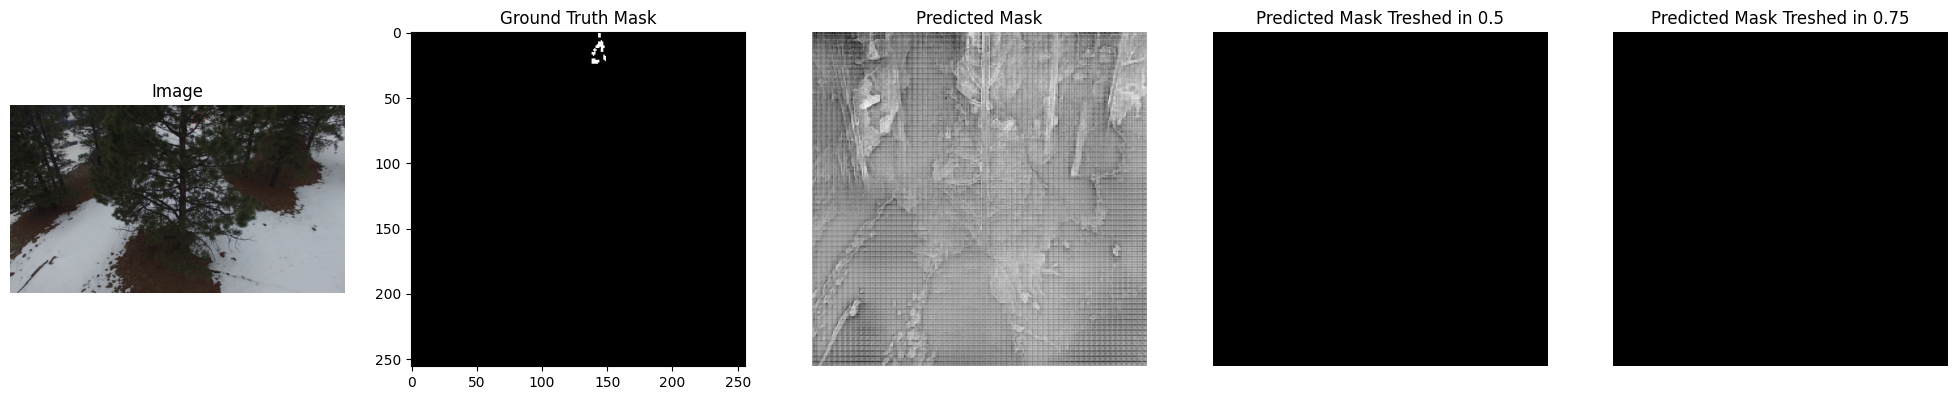

 86%|████████▌ | 60/70 [03:39<00:36,  3.61s/it]

F1-score para thresholder  0.5
Batch 60: GT sum: 807.0, Pred sum: 614.0
F1-score para thresholder  0.75
Batch 60: GT sum: 807.0, Pred sum: 611.0


100%|██████████| 70/70 [04:15<00:00,  3.65s/it]


EPOCH: 2
Mean loss: 0.27895967704909186
Mean F1-Score: 0.7232841971696997


  0%|          | 0/70 [00:00<?, ?it/s]

F1-score para thresholder  0.5
Batch 0: GT sum: 1346.0, Pred sum: 1208.0
F1-score para thresholder  0.75
Batch 0: GT sum: 1346.0, Pred sum: 1198.0


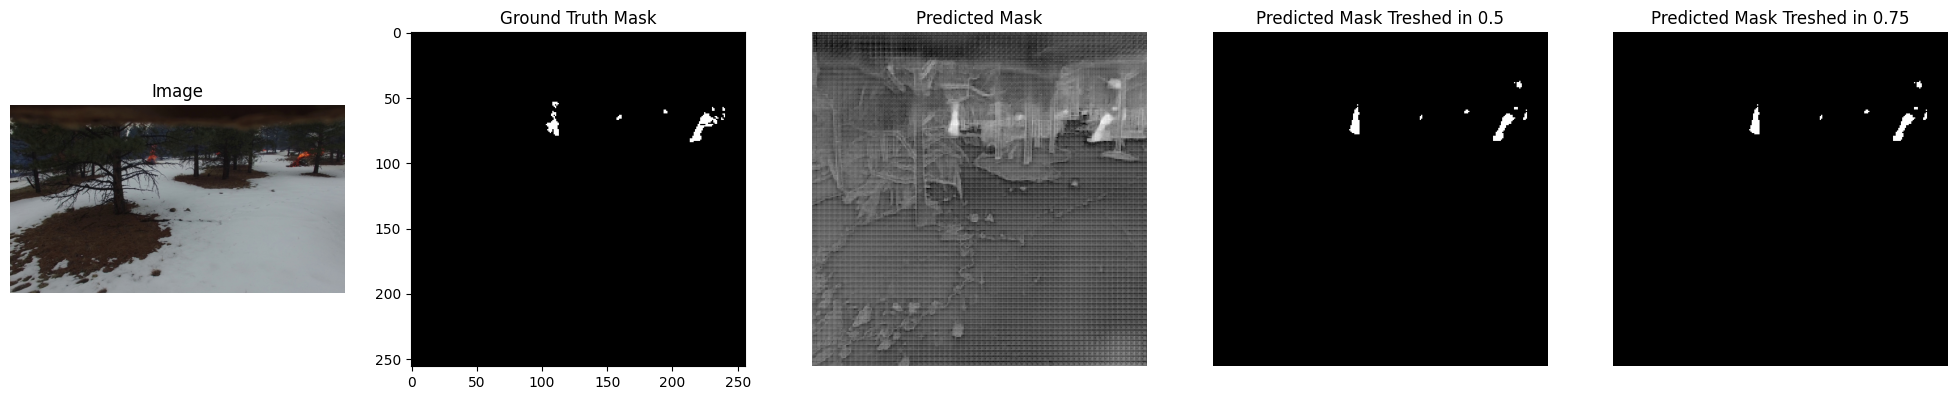

 14%|█▍        | 10/70 [00:37<03:35,  3.60s/it]

F1-score para thresholder  0.5
Batch 10: GT sum: 1165.0, Pred sum: 1046.0
F1-score para thresholder  0.75
Batch 10: GT sum: 1165.0, Pred sum: 1035.0


 29%|██▊       | 20/70 [01:13<02:59,  3.58s/it]

F1-score para thresholder  0.5
Batch 20: GT sum: 1021.0, Pred sum: 730.0
F1-score para thresholder  0.75
Batch 20: GT sum: 1021.0, Pred sum: 729.0


 36%|███▌      | 25/70 [01:30<02:40,  3.56s/it]

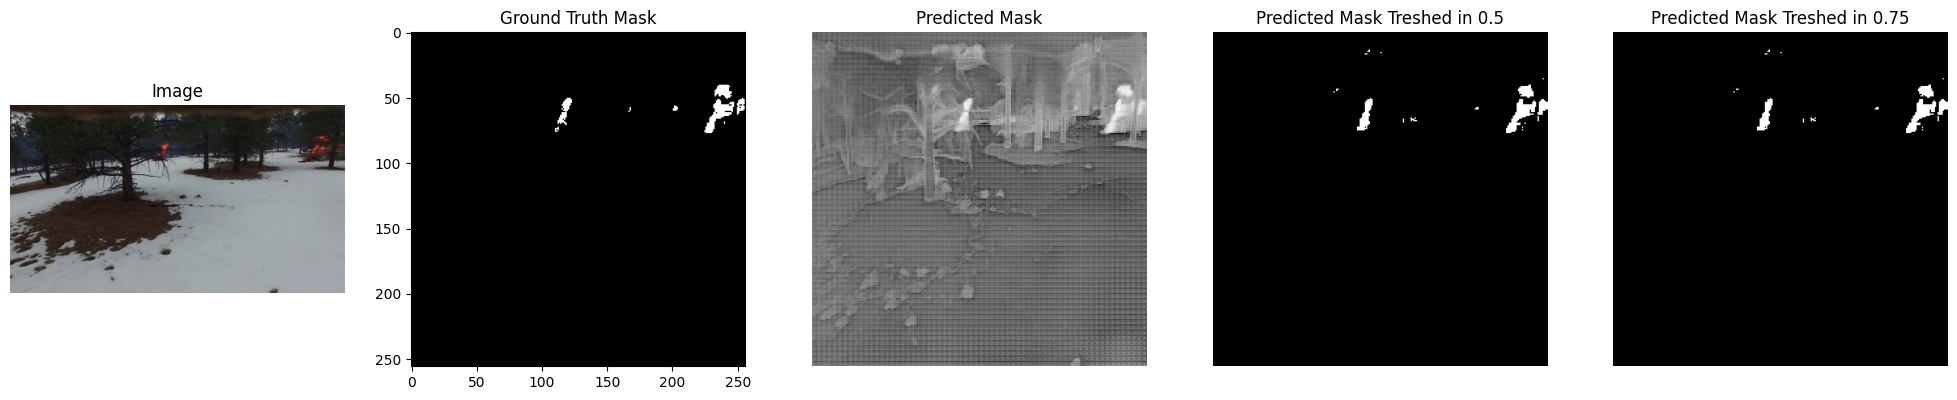

 43%|████▎     | 30/70 [01:50<02:26,  3.66s/it]

F1-score para thresholder  0.5
Batch 30: GT sum: 605.0, Pred sum: 461.0
F1-score para thresholder  0.75
Batch 30: GT sum: 605.0, Pred sum: 457.0


 57%|█████▋    | 40/70 [02:26<01:47,  3.58s/it]

F1-score para thresholder  0.5
Batch 40: GT sum: 966.0, Pred sum: 813.0
F1-score para thresholder  0.75
Batch 40: GT sum: 966.0, Pred sum: 805.0


 71%|███████▏  | 50/70 [03:01<01:11,  3.56s/it]

F1-score para thresholder  0.5
Batch 50: GT sum: 620.0, Pred sum: 255.0
F1-score para thresholder  0.75
Batch 50: GT sum: 620.0, Pred sum: 254.0


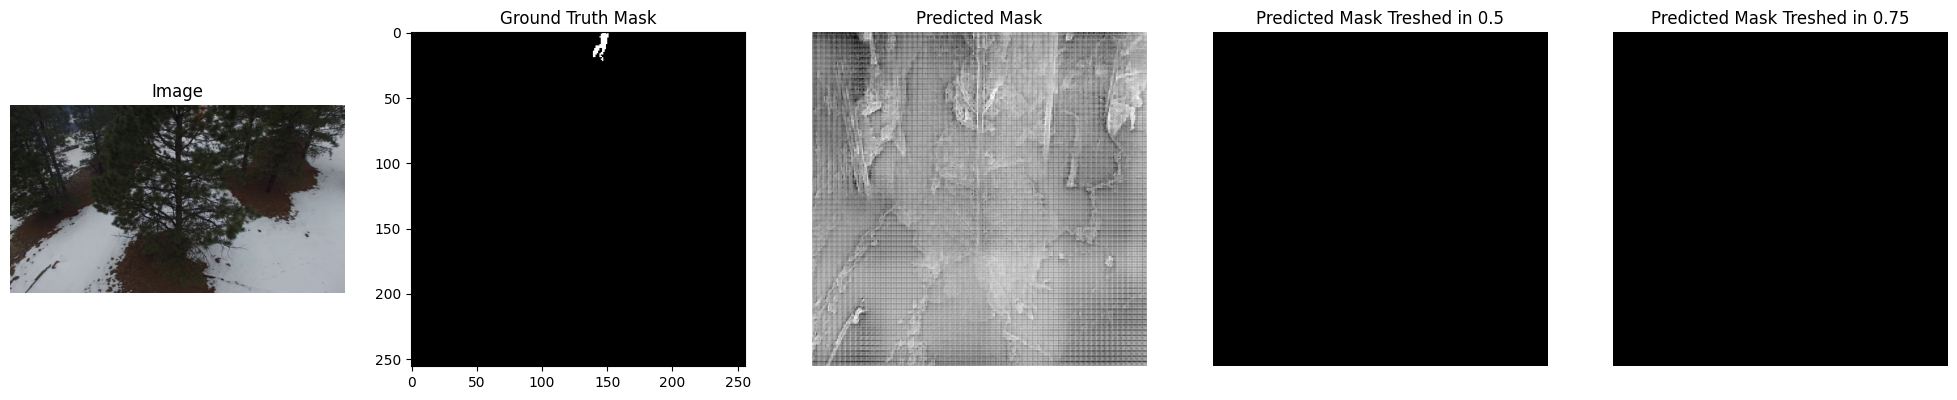

 86%|████████▌ | 60/70 [03:39<00:36,  3.60s/it]

F1-score para thresholder  0.5
Batch 60: GT sum: 1354.0, Pred sum: 1169.0
F1-score para thresholder  0.75
Batch 60: GT sum: 1354.0, Pred sum: 1165.0


100%|██████████| 70/70 [04:14<00:00,  3.64s/it]


EPOCH: 3
Mean loss: 0.2594653265816825
Mean F1-Score: 0.7423101780874195


  0%|          | 0/70 [00:00<?, ?it/s]

F1-score para thresholder  0.5
Batch 0: GT sum: 1048.0, Pred sum: 800.0
F1-score para thresholder  0.75
Batch 0: GT sum: 1048.0, Pred sum: 792.0


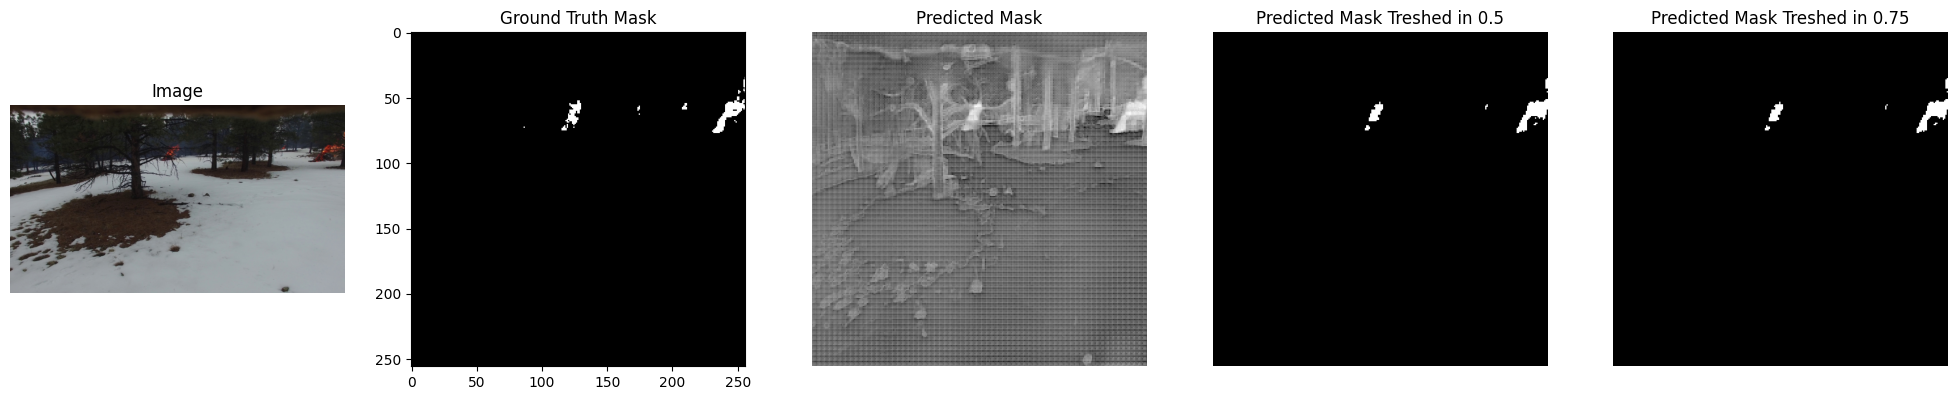

 14%|█▍        | 10/70 [00:37<03:37,  3.63s/it]

F1-score para thresholder  0.5
Batch 10: GT sum: 1011.0, Pred sum: 776.0
F1-score para thresholder  0.75
Batch 10: GT sum: 1011.0, Pred sum: 760.0


 29%|██▊       | 20/70 [01:13<02:58,  3.57s/it]

F1-score para thresholder  0.5
Batch 20: GT sum: 1081.0, Pred sum: 873.0
F1-score para thresholder  0.75
Batch 20: GT sum: 1081.0, Pred sum: 867.0


 36%|███▌      | 25/70 [01:30<02:40,  3.57s/it]

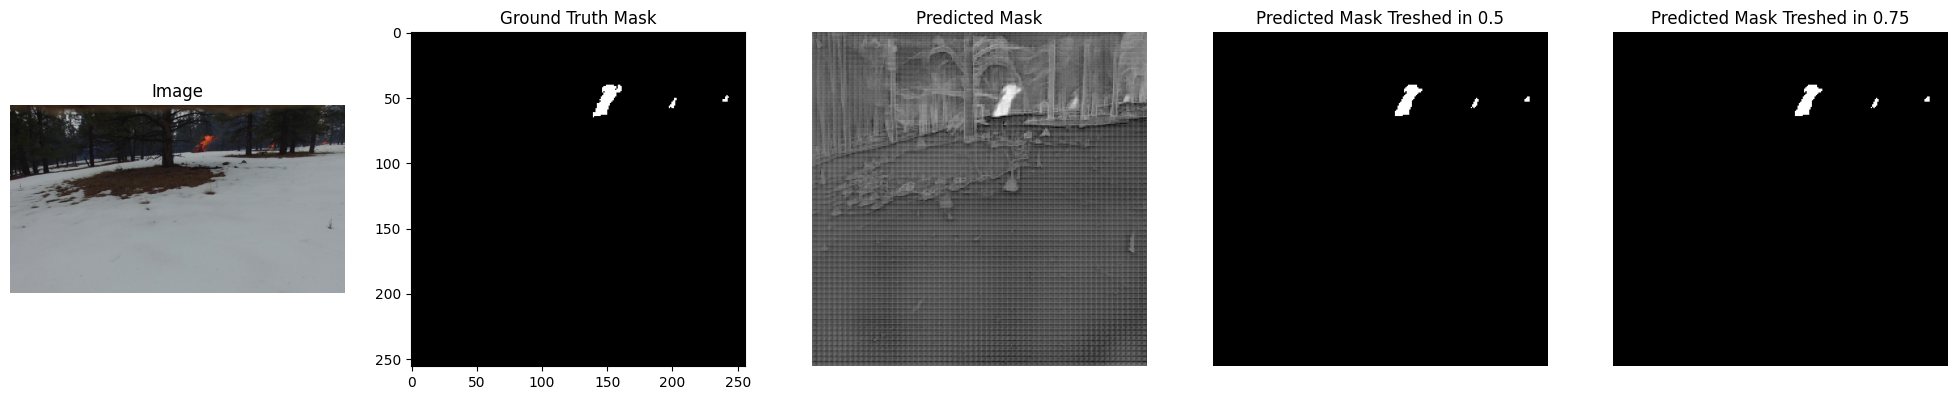

 43%|████▎     | 30/70 [01:50<02:24,  3.62s/it]

F1-score para thresholder  0.5
Batch 30: GT sum: 1002.0, Pred sum: 892.0
F1-score para thresholder  0.75
Batch 30: GT sum: 1002.0, Pred sum: 884.0


 57%|█████▋    | 40/70 [02:24<01:44,  3.47s/it]

F1-score para thresholder  0.5
Batch 40: GT sum: 1251.0, Pred sum: 1236.0
F1-score para thresholder  0.75
Batch 40: GT sum: 1251.0, Pred sum: 1227.0


 71%|███████▏  | 50/70 [02:59<01:08,  3.45s/it]

F1-score para thresholder  0.5
Batch 50: GT sum: 1020.0, Pred sum: 859.0
F1-score para thresholder  0.75
Batch 50: GT sum: 1020.0, Pred sum: 847.0


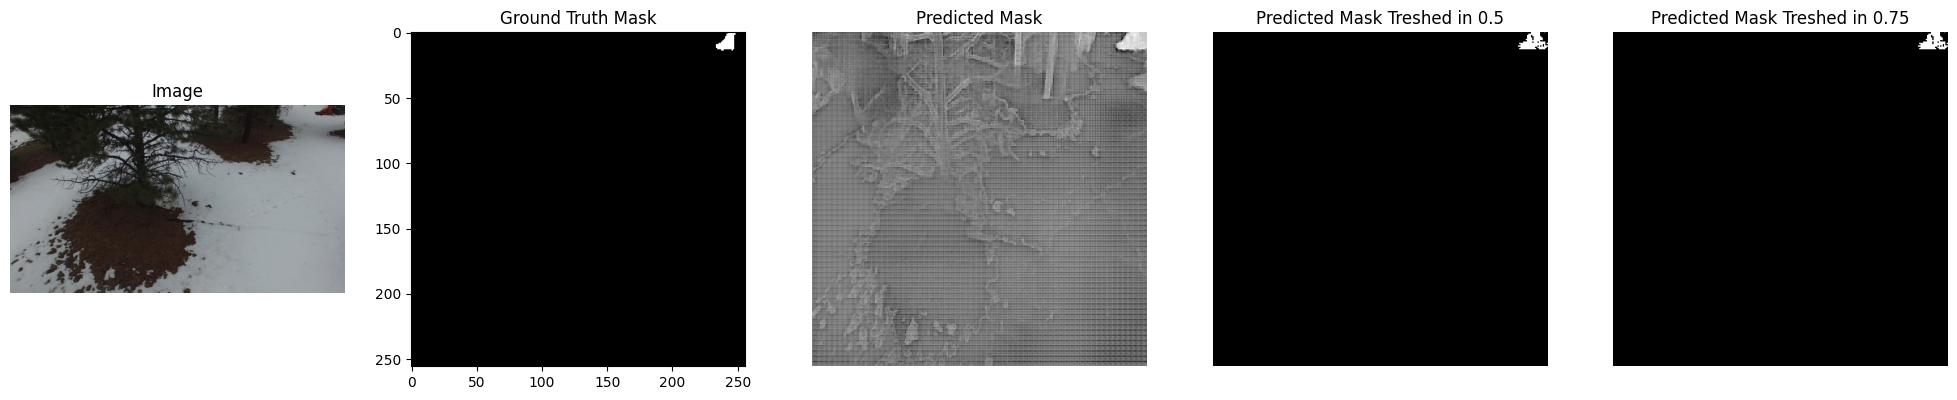

 86%|████████▌ | 60/70 [03:35<00:34,  3.47s/it]

F1-score para thresholder  0.5
Batch 60: GT sum: 1181.0, Pred sum: 1100.0
F1-score para thresholder  0.75
Batch 60: GT sum: 1181.0, Pred sum: 1095.0


100%|██████████| 70/70 [04:09<00:00,  3.57s/it]

EPOCH: 4
Mean loss: 0.23576212440218244
Mean F1-Score: 0.7657060853293841


In [10]:

from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize
from sklearn.metrics import f1_score

# Training loop
epoch_advance = []
score_advance = []

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    f1_scores = []
    
    for i, batch in enumerate(tqdm(train_dataloader)):
        optimizer.zero_grad()
        # Forward pass
        outputs = model(pixel_values=batch["pixel_values"].to(device),
                        input_boxes=batch["input_boxes"].to(device),
                        multimask_output=False)

        # Compute loss
        predicted_masks = outputs.pred_masks.squeeze(1)
        ground_truth_masks = batch["ground_truth_mask"].float().to(device)
        #print("Tamanho AONINDINS", predicted_masks.size())
        #print(ground_truth_masks.size())
        loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

        # Backward pass (compute gradients of parameters w.r.t. loss)
        
        loss.backward()

        # Optimize
        optimizer.step()
        epoch_losses.append(loss.item())
        
        # Calculate F1-Score
        for th in thold:
            binarized_predicted_masks = (predicted_masks > th).float()
            #print(np.max(ground_truth_masks[0].cpu().numpy()))
            binarized_ground_truth_masks = (ground_truth_masks > th).float()
            
            # Flatten to compare all pixels
            pred_flat = binarized_predicted_masks.view(-1).cpu().numpy()
            gt_flat = binarized_ground_truth_masks.view(-1).cpu().numpy()

            if i % 10 == 0:  # Checar periodicamente
                print("F1-score para thresholder ", th)
                print(f'Batch {i}: GT sum: {gt_flat.sum()}, Pred sum: {pred_flat.sum()}')
    
            if gt_flat.sum() == 0 and pred_flat.sum() == 0:
                f1 = 1.0  # Ambos são completamente negativos, atribuímos 1 como F1 perfeito
            else:
                f1 = f1_score(gt_flat, pred_flat, average="binary", zero_division=0)
            f1_scores.append(f1)

        # Plot images, masks, and predictions every 10 iterations
        if i % 25 == 0:
            # Get the image and mask for visualization
            # Converter para o intervalo [0, 255]
            test_image = (batch["pixel_values"][0].cpu().numpy().transpose(1, 2, 0) * 255).astype('uint8')  # Assuming the image is [C, H, W]
            # Corrige o tipo de dado antes de criar a imagem PIL
            test_image_uint8 = test_image.astype('uint8')
            
            # Agora crie a imagem PIL corretamente
            pil_image = Image.fromarray(test_image_uint8)
            test_image = pil_image.resize((3840, 2160), Image.BILINEAR)
            ground_truth_mask = (ground_truth_masks[0].cpu().numpy() * 255).astype('uint8')
            pred_mask = predicted_masks[0].cpu().detach().numpy()[0]

            # Create a plot with 3 subplots: image, ground truth mask, and predicted mask
            t = len(thold)
            fig, axes = plt.subplots(1, 3+t, figsize=(5*(3+t), 5))

            # Plot the original image
            axes[0].imshow(test_image)
            axes[0].set_title("Image")
            axes[0].axis('off')

            # Plot the ground truth mask
            axes[1].imshow(ground_truth_mask, cmap='gray')
            axes[1].set_title("Ground Truth Mask")
            #axes[1].axis('off')

            # Plot the predicted mask
            axes[2].imshow(pred_mask, cmap='gray')
            axes[2].set_title("Predicted Mask")
            axes[2].axis('off')

            # Plot the binarized mask
            h = 0
            for th in thold:
                binarized_predicted_masks = (pred_mask > th)
                axes[3+h].imshow(binarized_predicted_masks, cmap='gray')
                axes[3+h].set_title(f"Predicted Mask Treshed in {th}")
                axes[3+h].axis('off')
                h+=1

            plt.show()

    print(f'EPOCH: {epoch}')
    epoch_advance.append(mean(epoch_losses))
    score_advance.append(mean(f1_scores))
    print(f'Mean loss: {mean(epoch_losses)}')
    print(f'Mean F1-Score: {mean(f1_scores)}')


In [11]:
# Save the model's state dictionary to a file
torch.save(model.state_dict(), "/kaggle/working/flame_model_checkpoint.pth")

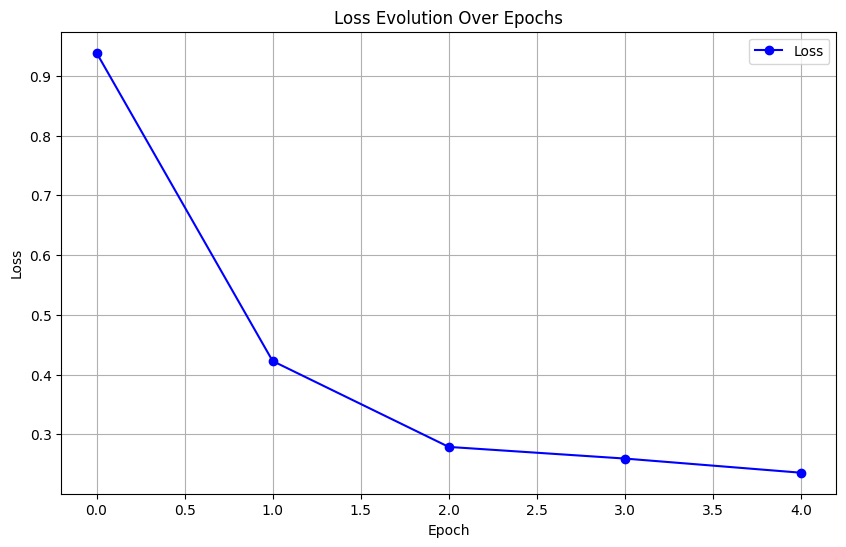

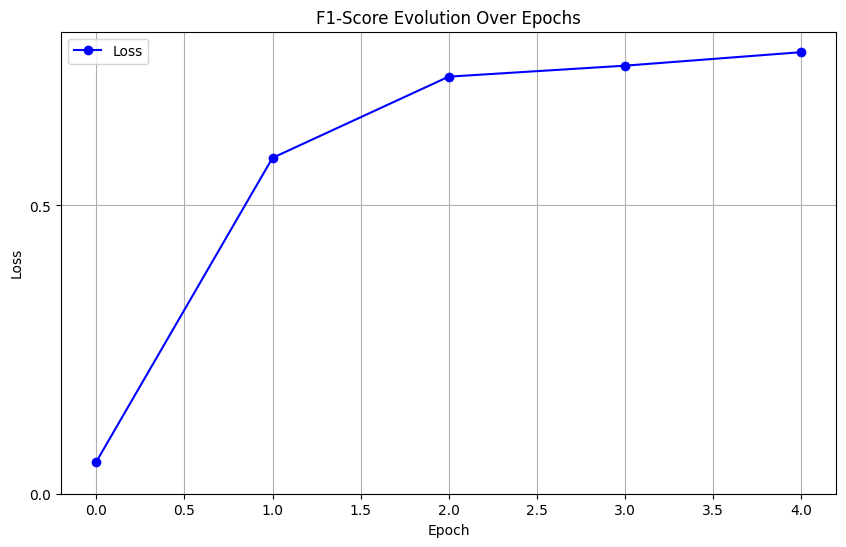

In [12]:
# After training, plot the loss evolution
plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), epoch_advance, marker='o', color='b', label='Loss')
plt.title('Loss Evolution Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.yticks(np.arange(0., 0.7, step=0.01))
plt.legend()
plt.grid(True)
plt.show()

# After training, plot the loss evolution
plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), score_advance, marker='o', color='b', label='Loss')
plt.title('F1-Score Evolution Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yticks(np.arange(0, 1, step=0.5))
plt.legend()
plt.grid(True)
plt.show()

  0%|          | 0/15 [00:00<?, ?it/s]

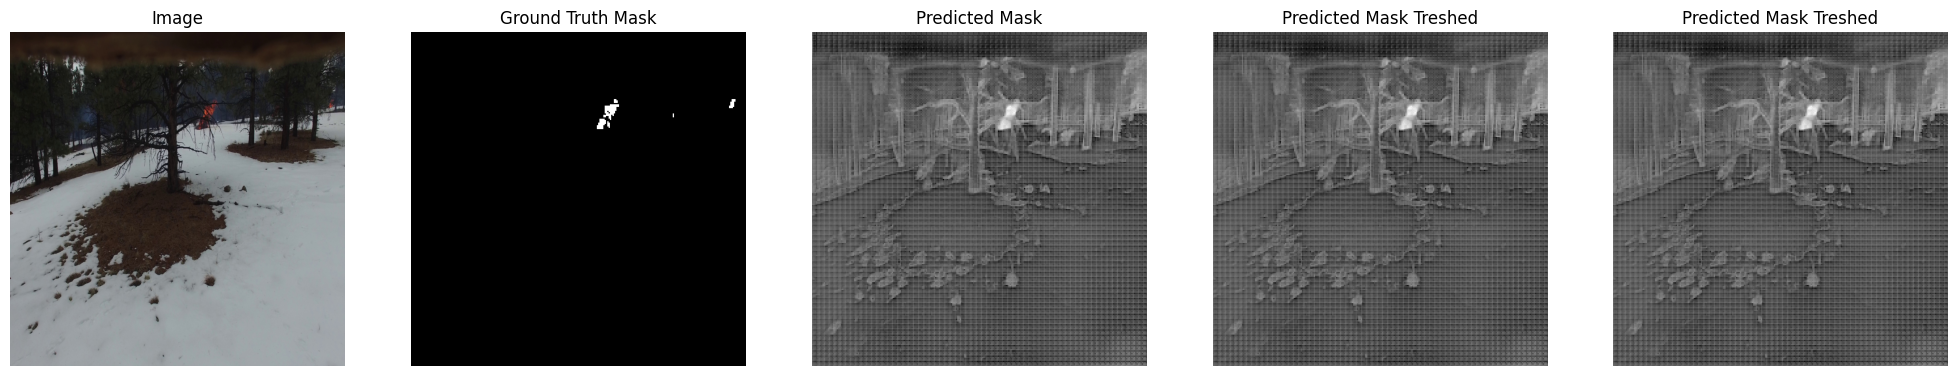

 33%|███▎      | 5/15 [00:16<00:31,  3.19s/it]

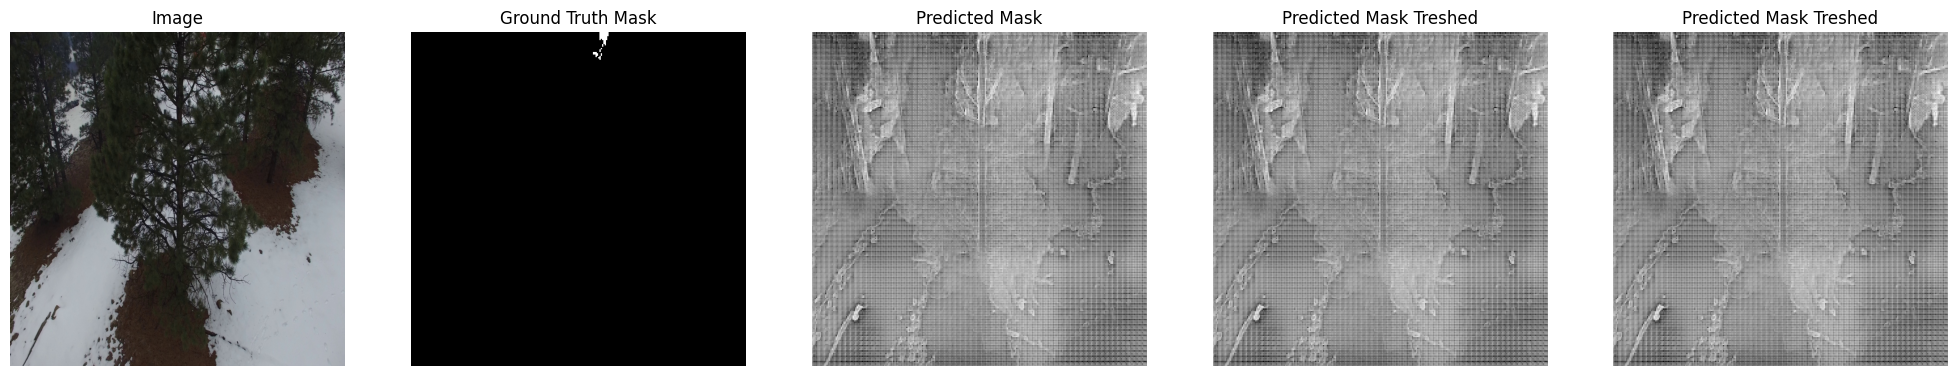

 67%|██████▋   | 10/15 [00:33<00:16,  3.33s/it]

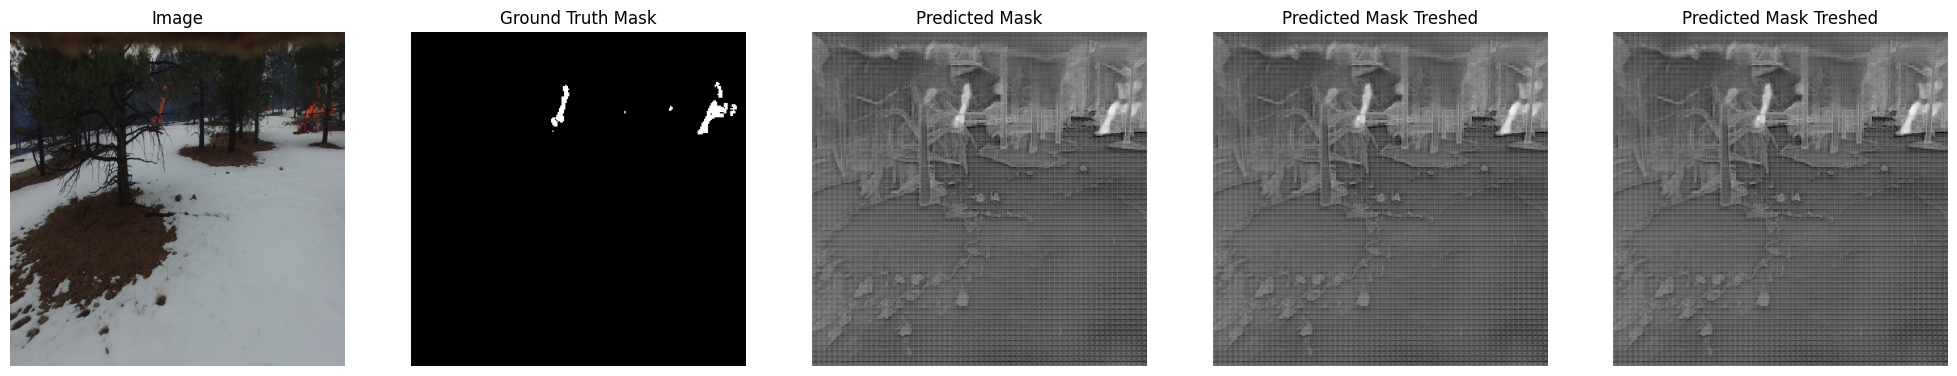

100%|██████████| 15/15 [00:50<00:00,  3.37s/it]

Mean validation loss: 0.24001298348108926
Mean validation score: 0.7503908285565399


In [20]:
# Prediction on validation set
model.eval()  # Set the model to evaluation mode

i = 0

with torch.no_grad():  # Disable gradient computation
    val_losses = []
    val_f1_scores = []
    for batch in tqdm(val_dataloader):
        # Forward pass
        outputs = model(pixel_values=batch["pixel_values"].to(device),
                        input_boxes=batch["input_boxes"].to(device),
                        multimask_output=False)

        # Compute the predicted masks and ground truth
        predicted_masks = outputs.pred_masks.squeeze(1)  # Remove extra dimension
        ground_truth_masks = batch["ground_truth_mask"].float().to(device)

        # Compute loss for the validation set
        loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))
        val_losses.append(loss.item())
        
        # Calculate F1-Score
        for th in thold:
            binarized_predicted_masks = (predicted_masks > th)
            #print(np.max(ground_truth_masks[0].cpu().numpy()))
            binarized_ground_truth_masks = (ground_truth_masks > th)
            
            # Flatten to compare all pixels
            pred_flat = binarized_predicted_masks.view(-1).cpu().numpy()
            gt_flat = binarized_ground_truth_masks.view(-1).cpu().numpy()
            val_f1_scores.append(f1)

        # Optionally: Do something with the predicted masks, e.g., save them or visualize
        # For example, save the masks as images or output metrics
        # You can also visualize the predictions if you want (e.g., plot with matplotlib)

        # Plot images, masks, and predictions every 5 iterations
        if i % 5 == 0:
            # Get the image and mask for visualization
            test_image = batch["pixel_values"][0].cpu().numpy().transpose(1, 2, 0)  # Assuming the image is [C, H, W]
            ground_truth_mask = ground_truth_masks[0].cpu().numpy()
            pred_mask = predicted_masks[0].cpu().numpy()[0]

            t = len(thold)
            # Create a plot with 3 subplots: image, ground truth mask, and predicted mask
            fig, axes = plt.subplots(1, (3+t), figsize=(5*(3+t), 5))

            # Plot the original image
            axes[0].imshow(test_image)
            axes[0].set_title("Image")
            axes[0].axis('off')

            # Plot the ground truth mask
            axes[1].imshow(ground_truth_mask, cmap='gray')
            axes[1].set_title("Ground Truth Mask")
            axes[1].axis('off')

            # Plot the predicted mask
            axes[2].imshow(pred_mask, cmap='gray')
            axes[2].set_title("Predicted Mask")
            axes[2].axis('off')

            h=0
            for th in thold:
                binarized_predicted_masks = (pred_mask > th)
                # Plot the predicted mask
                axes[3+h].imshow(pred_mask, cmap='gray')
                axes[3+h].set_title("Predicted Mask Treshed")
                axes[3+h].axis('off')
                h+=1
                

            plt.show()
        i += 1

    print(f'Mean validation loss: {mean(val_losses)}')
    print(f'Mean validation score: {mean(val_f1_scores)}')

# Optional: Save predictions to disk or visualize


In [14]:
model_old = SamModel.from_pretrained("facebook/sam-vit-base")
model_old.to(device)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

  0%|          | 0/15 [00:00<?, ?it/s]

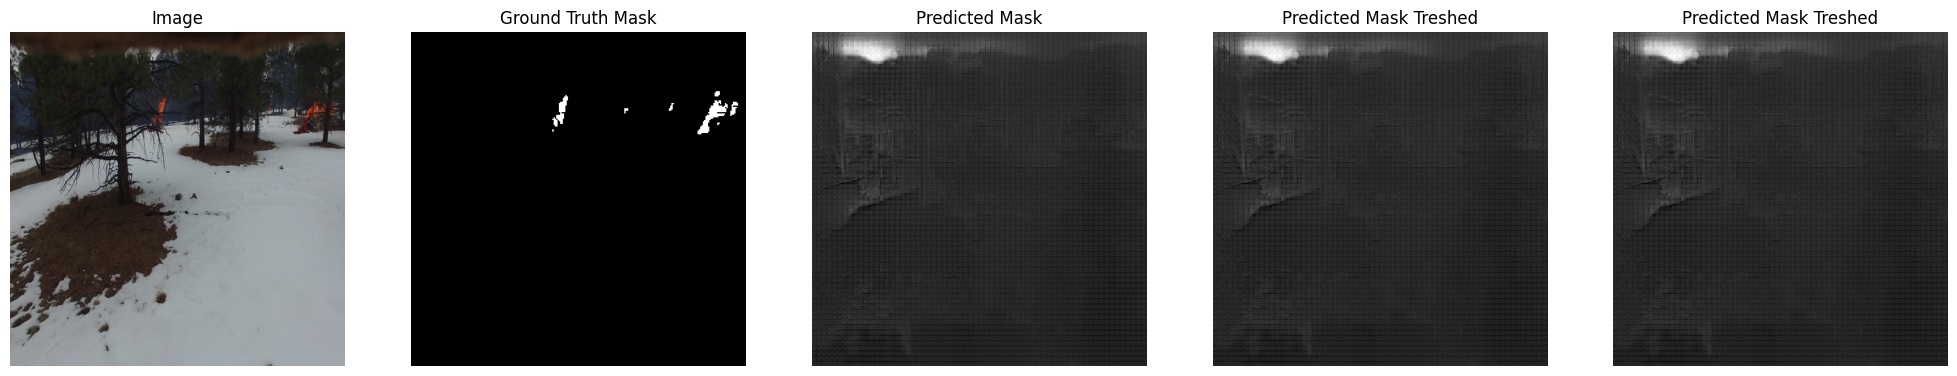

 33%|███▎      | 5/15 [00:16<00:32,  3.23s/it]

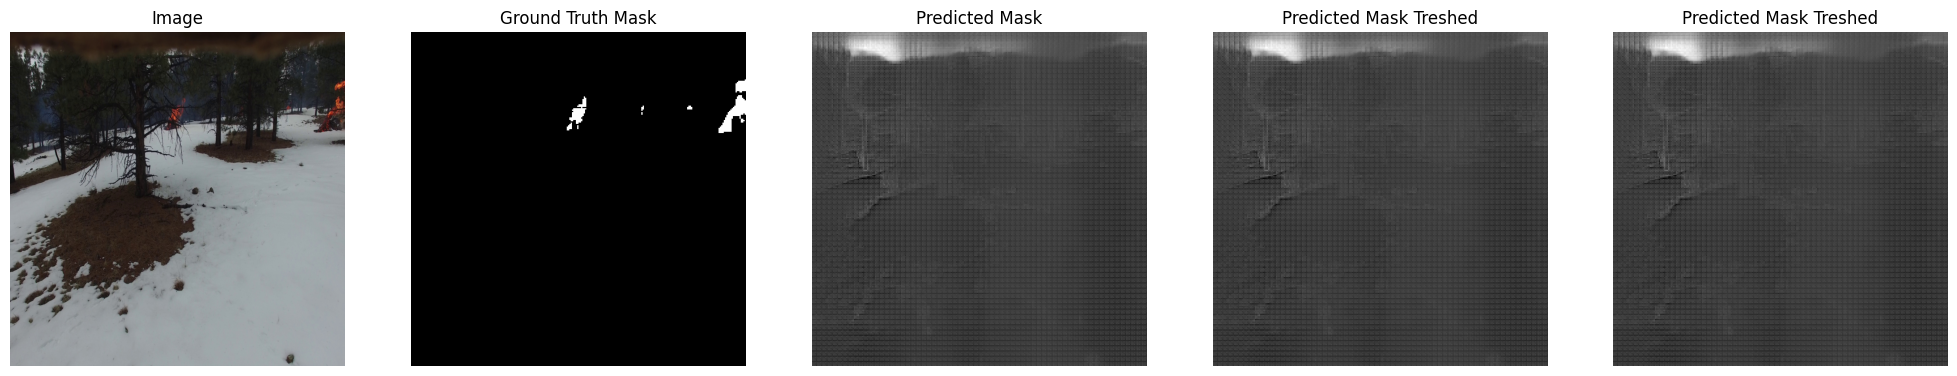

 67%|██████▋   | 10/15 [00:33<00:16,  3.34s/it]

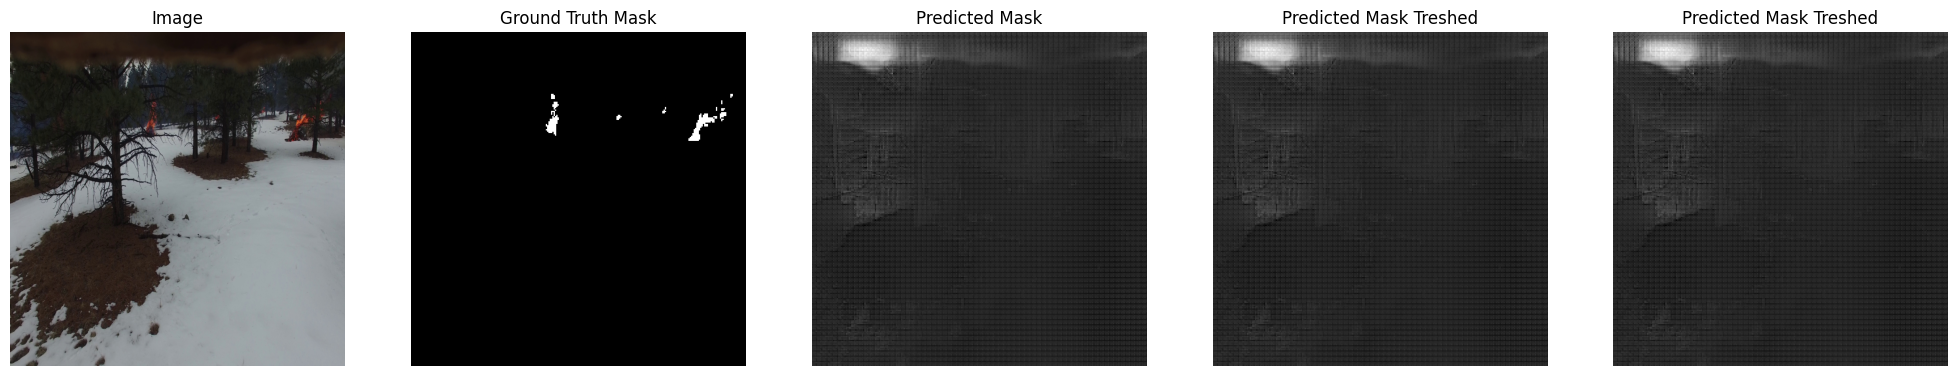

100%|██████████| 15/15 [00:50<00:00,  3.40s/it]

Mean validation loss: 0.999387284119924
Mean score loss: 0.7503908285565399


In [17]:
import matplotlib.pyplot as plt

# Prediction on validation set
model_old.eval()  # Set the model_old to evaluation mode

with torch.no_grad():  # Disable gradient computation
    val_losses = []
    base_f1_scores = []
    for i, batch in enumerate(tqdm(val_dataloader)):
        # Forward pass
        outputs = model_old(pixel_values=batch["pixel_values"].to(device),
                            input_boxes=batch["input_boxes"].to(device),
                            multimask_output=False)

        # Compute the predicted masks and ground truth
        predicted_masks = outputs.pred_masks.squeeze(1)  # Remove extra dimension
        ground_truth_masks = batch["ground_truth_mask"].float().to(device)

        # Compute loss for the validation set
        loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))
        val_losses.append(loss.item())

        for th in thold:
            # Calculate F1-Score
            binarized_predicted_masks = (predicted_masks > th).float()
            #print(np.max(ground_truth_masks[0].cpu().numpy()))
            binarized_ground_truth_masks = (ground_truth_masks > th).float()
            
            # Flatten to compare all pixels
            pred_flat = binarized_predicted_masks.view(-1).cpu().numpy()
            gt_flat = binarized_ground_truth_masks.view(-1).cpu().numpy()
            base_f1_scores.append(f1)

        # Plot images, masks, and predictions every 5 iterations
        if i % 5 == 0:
            # Get the image and mask for visualization
            test_image = batch["pixel_values"][0].cpu().numpy().transpose(1, 2, 0)  # Assuming the image is [C, H, W]
            ground_truth_mask = ground_truth_masks[0].cpu().numpy()
            pred_mask = predicted_masks[0].cpu().numpy()[0]

            t = len(thold)
            # Create a plot with 3 subplots: image, ground truth mask, and predicted mask
            fig, axes = plt.subplots(1, (3+t), figsize=(5*(3+t), 5))

            # Plot the original image
            axes[0].imshow(test_image)
            axes[0].set_title("Image")
            axes[0].axis('off')

            # Plot the ground truth mask
            axes[1].imshow(ground_truth_mask, cmap='gray')
            axes[1].set_title("Ground Truth Mask")
            axes[1].axis('off')

            # Plot the predicted mask
            axes[2].imshow(pred_mask, cmap='gray')
            axes[2].set_title("Predicted Mask")
            axes[2].axis('off')

            h=0
            for th in thold:
                binarized_predicted_masks = (pred_mask > th)
                # Plot the predicted mask
                axes[3+h].imshow(pred_mask, cmap='gray')
                axes[3+h].set_title("Predicted Mask Treshed")
                axes[3+h].axis('off')
                h+=1
                
            plt.show()

    print(f'Mean validation loss: {mean(val_losses)}')
    print(f'Mean score loss: {mean(base_f1_scores)}')


In [16]:
test_image = batch["pixel_values"][0].cpu().numpy().transpose(1, 2, 0)  # Assuming the image is [C, H, W]
ground_truth_mask = ground_truth_masks[0].cpu().numpy()
pred_mask = predicted_masks[0].cpu().detach().numpy()[0]

# Corrige o tipo de dado antes de criar a imagem PIL
test_image_uint8 = test_image.astype('uint8')

# Agora crie a imagem PIL corretamente
pil_image = Image.fromarray(test_image_uint8)
resized_image = pil_image.resize((3840, 2160), Image.BILINEAR)

print(resized_image)
print(test_image)
print(np.max(test_image))
print(ground_truth_mask)
print("Maximo: ", np.max(ground_truth_mask))
print(pred_mask)

<PIL.Image.Image image mode=RGB size=3840x2160 at 0x79BDEC6F7DC0>
[[[0.09019608 0.09411765 0.07058824]
  [0.08627451 0.09019608 0.06666667]
  [0.07450981 0.07843138 0.05490196]
  ...
  [0.2        0.20784314 0.19607843]
  [0.23921569 0.24705882 0.23529412]
  [0.14901961 0.15686275 0.14509805]]

 [[0.09019608 0.09411765 0.07058824]
  [0.09019608 0.09411765 0.07058824]
  [0.07843138 0.08235294 0.05882353]
  ...
  [0.31764707 0.3254902  0.3137255 ]
  [0.25882354 0.26666668 0.25490198]
  [0.15294118 0.16078432 0.14901961]]

 [[0.09411765 0.09803922 0.07450981]
  [0.09019608 0.09411765 0.07058824]
  [0.08627451 0.09019608 0.06666667]
  ...
  [0.32156864 0.32941177 0.31764707]
  [0.2627451  0.27058825 0.25882354]
  [0.15294118 0.16078432 0.14901961]]

 ...

 [[0.627451   0.6392157  0.65882355]
  [0.6        0.6117647  0.6313726 ]
  [0.49803922 0.50980395 0.5254902 ]
  ...
  [0.5764706  0.6039216  0.627451  ]
  [0.6039216  0.6313726  0.654902  ]
  [0.6117647  0.6392157  0.6627451 ]]

 [[0.615